In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter

import numpy as np
import os 
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns




In [3]:
dataset_path = "C:/Users/karishma/Desktop/Blood_Grp_Detection_Using_Fingerprint/dataset/dataset_blood_group"

In [4]:
BATCH_SIZE =32

In [5]:
dataset = image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64, 64),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 6000 files belonging to 8 classes.


In [6]:
class_names = dataset.class_names
class_counts = Counter()
for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1

print("Class Distribution:")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")


Class Distribution:
B-: 741
A-: 1009
AB+: 708
AB-: 761
O+: 852
O-: 712
B+: 652
A+: 565


In [7]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_names, class_counts):
    """
    Plots the distribution of classes in the dataset.

    Parameters:
    - class_names (list): List of class names.
    - class_counts (dict): Dictionary with class indices as keys and counts as values.

    Returns:
    - None
    """
    # Extract class names and their corresponding counts
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


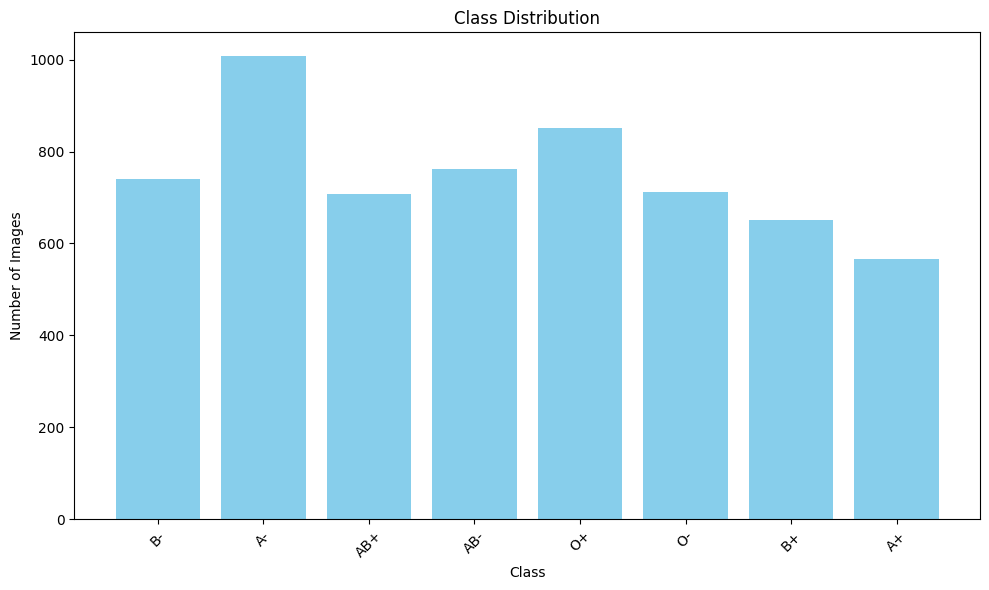

In [8]:
plot_class_distribution(class_names, class_counts)

In [9]:
max_count = max(class_counts.values())

In [10]:
def oversample_class(class_id, count, max_count):
    unbatched_dataset = dataset.unbatch()
    class_dataset = unbatched_dataset.filter(lambda img,lbl:tf.equal(lbl,class_id))
    repeat_factor = max_count // count + (max_count % count > 0)
    return class_dataset.repeat(repeat_factor).take(max_count)
    

In [11]:
# step 1 balance the dataset 

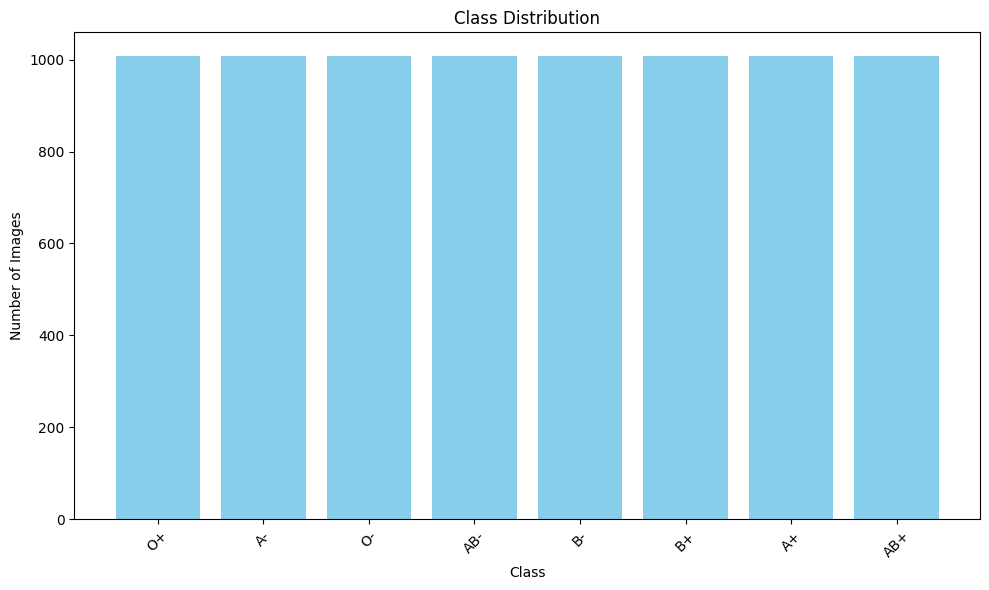

In [12]:
balanced_datasets = []  # Fixed typo

for class_id, count in class_counts.items():  # Fixed method name
    balanced_datasets.append(oversample_class(class_id, count, max_count))  # Fixed function name if needed

# Step 2: Combine balanced datasets
balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)

# Step 3: Check balanced class distribution
balanced_class_counts = Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution(class_names, balanced_class_counts)

# Step 4: Batch the balanced dataset
balanced_dataset = balanced_dataset.batch(BATCH_SIZE, drop_remainder=True)


                             

In [13]:
for sample in balanced_dataset.take(10):
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [14]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}")

Total dataset size: 8064


In [15]:
# Define ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Compute dataset size from unbatched dataset
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)

# Reset unbatched dataset for use after size computation
balanced_dataset_unbatched = balanced_dataset.unbatch()

# Split the dataset
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

train_dataset = balanced_dataset_unbatched.take(train_size)
val_test_dataset = balanced_dataset_unbatched.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Rebatch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Count and print
train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")


Training dataset size: 5632
Validation dataset size: 1184
Testing dataset size: 1184


In [16]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the model
def create_high_accuracy_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    # 🛠️ Fix: 'optimizers' → 'optimizer', and 'admin' → 'adam'
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Instantiate the model
high_acc_model = create_high_accuracy_model()

C:\Users\karishma\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# Ensure train_dataset repeats indefinitely
train_dataset = train_dataset.repeat()

# Calculate steps per epoch
steps_per_epoch = train_size // BATCH_SIZE

# Optional: data augmentation / dropout in your model can help generalize

# Update callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Extend early stopping patience or disable it for full 50 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,  # <-- Increased from default
    restore_best_weights=True,
    verbose=1
)

# Train model for full 50 epochs (unless early_stop patience triggers late)
history_high_src = high_acc_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    callbacks=[reduce_lr, early_stop]  # or just remove early_stop to train full
)


Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 87s 491ms/step - accuracy: 0.8473 - loss: 0.4100 - val_accuracy: 0.8865 - val_loss: 0.3832 - learning_rate: 2.5000e-04
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 467ms/step - accuracy: 0.8549 - loss: 0.3724 - val_accuracy: 0.8898 - val_loss: 0.4027 - learning_rate: 2.5000e-04
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 446ms/step - accuracy: 0.8647 - loss: 0.3435 - val_accuracy: 0.8783 - val_loss: 0.4519 - learning_rate: 2.5000e-04
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 468ms/step - accuracy: 0.8502 - loss: 0.3707 - val_accuracy: 0.8717 - val_loss: 0.3616 - learning_rate: 2.5000e-04
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 472ms/step - accuracy: 0.8704 - loss: 0.3361 - val_accuracy: 0.8816 - val_loss: 0.3679 - learning_rate: 2.5000e-04
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 85s 484ms/step - accuracy: 0.8743 - loss: 0.3153 - val_accuracy: 0.8914 - val_loss: 0.3475 - learning_rate: 2.5000e-04
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 44

In [21]:
#Evaluate the model on validation data 
high_acc_eval = high_acc_model.evaluate(val_dataset)
print(f"High Accuracy Model - Loss: {high_acc_eval[0]},{high_acc_eval[1]}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 178ms/step - accuracy: 0.9562 - loss: 0.2087
High Accuracy Model - Loss: 0.19344787299633026,0.9375


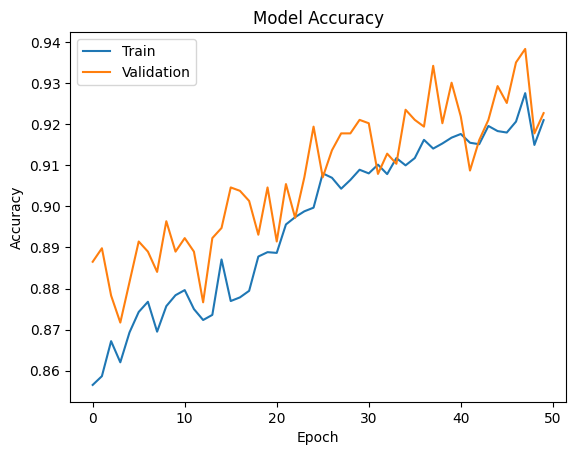

In [24]:
import matplotlib.pyplot as plt 

# Plot training & validation accuracy values
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')  # ✅ fixed here
    plt.show()

plot_accuracy(history_high_src)  # assuming your history variable is history_high_src


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/ste

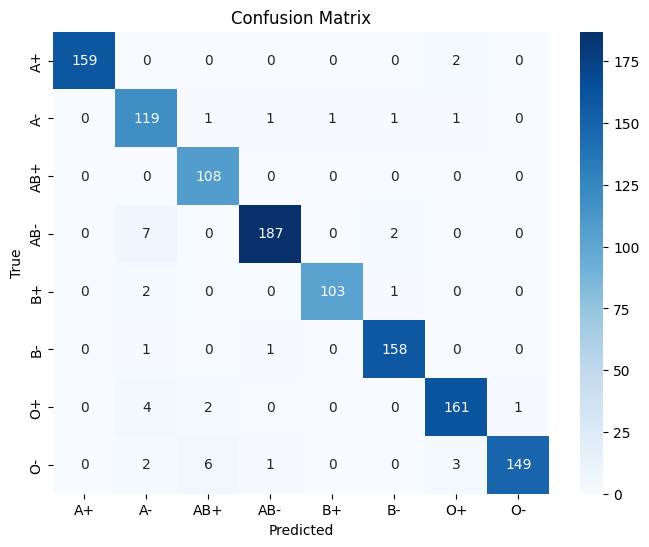

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions on the test dataset
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = high_acc_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# ✅ Corrected this line
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [27]:
high_acc_model.save('model.h5') #the model will be saved asnmy_model.h5')
print("Model saved as HDFS format,")

Model saved as HDFS format,


In [1]:
!pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
